# Biomedical Data Processing and Analysis
## Processing output_cleaned.csv

This notebook processes and analyzes the biomedical dataset containing demographic and health information.

### 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 2. Load the Data

In [3]:
# Load the CSV file
df = pd.read_csv('data_clearance/output_cleaned.csv')

### 3. Initial Data Exploration

In [4]:
# Display first few rows
df.head(10)

### 4. Data Quality Assessment

In [ ]:
# Check for missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_data

### 4.1. Height Classification and Standardization

In [ ]:
# Classify height values based on their ranges
def classify_height_unit(height):
    """Classify height unit based on value range"""
    if pd.isna(height):
        return 'Unknown'
    elif height >= 50:  # Likely centimeters
        return 'Centimeters'
    elif height >= 3:   # Likely feet
        return 'Feet'
    else:               # Likely meters
        return 'Meters'

df['Height_Unit'] = df['Yourheight'].apply(classify_height_unit)

In [ ]:
# Standardize all heights to meters
def standardize_height_to_meters(height):
    """Convert height to meters based on detected unit"""
    if pd.isna(height):
        return np.nan
    elif height >= 50:  # Centimeters -> Meters
        return height / 100
    elif height >= 3:   # Feet -> Meters
        return height * 0.3048
    else:               # Already in meters
        return height

df['Height_Original'] = df['Yourheight'].copy()
df['Yourheight'] = df['Yourheight'].apply(standardize_height_to_meters)

In [ ]:
# Check for potential outliers after standardization
outliers_low = df[df['Yourheight'] < 1.3]
outliers_high = df[df['Yourheight'] > 2.2]

In [ ]:
# Clean up temporary columns
df = df.drop(columns=['Height_Unit', 'Height_Original'])

### 4.2. Detect and Remove Duplicates

In [8]:
# Check for duplicate records
duplicate_count = df.duplicated().sum()
duplicates = df[df.duplicated(keep=False)].sort_values(by=list(df.columns)) if duplicate_count > 0 else None

In [9]:
# Check for duplicates based on key demographic fields
key_columns = ['Howoldareyou', 'Areyoumaleorfemale', 'MaritalStatus', 
               'Whatisyourhighestlevelofeducation', 'Yourbodyweight', 'Yourheight']

duplicate_count_key = df.duplicated(subset=key_columns, keep=False).sum()
duplicates_key = df[df.duplicated(subset=key_columns, keep=False)].sort_values(by=key_columns) if duplicate_count_key > 0 else None

In [10]:
# Detailed duplicate analysis
if duplicate_count > 0:
    duplicate_groups = df[df.duplicated(keep=False)].groupby(list(df.columns)).size().reset_index(name='count')
    duplicate_groups = duplicate_groups.sort_values('count', ascending=False)

In [11]:
# Remove duplicates
df_no_duplicates = df.drop_duplicates(keep='first')

In [12]:
# Save the deduplicated data with specific format
df_output = df_no_duplicates.copy()
df_output = df_output.reset_index(drop=True)
df_output.index = df_output.index + 1
df_output.insert(0, '@_index', df_output.index)

df_output = df_output.rename(columns={
    'Areyoumaleorfemale': 'sex',
    'MaritalStatus': 'mstatus'
})

column_order = ['@_index', 'Howoldareyou', 'Yourbodyweight', 'Yourheight', 
                'sex', 'mstatus', 'Whatisyourhighestlevelofeducation']
df_output = df_output[column_order]

output_path_no_dup = 'data_clearance/output_no_duplicates.csv'
df_output.to_csv(output_path_no_dup, index=True, index_label='#')

# Update the main dataframe for subsequent analysis
df = df_no_duplicates.copy()

In [13]:
# Check unique values for categorical columns
categorical_cols = ['MaritalStatus', 'Areyoumaleorfemale', 'Whatisyourhighestlevelofeducation']
for col in categorical_cols:
    df[col].value_counts()

### 5. Data Cleaning and Preparation

In [14]:
# Create a copy for cleaning
df_clean = df.copy()

# Rename columns for easier handling
df_clean.columns = ['Age', 'MaritalStatus', 'Gender', 'Education', 'Weight', 'Height']

print("Columns renamed successfully")
print(df_clean.columns.tolist())

In [15]:
# Identify and handle height outliers
# Heights > 3 are likely in cm and need conversion to meters
print("Height values analysis:")
print(f"Height range: {df_clean['Height'].min()} - {df_clean['Height'].max()}")
print(f"\nRows with height > 3.0:")
print(df_clean[df_clean['Height'] > 3.0][['Height', 'Weight', 'Age']])

# Convert heights > 3 from cm to meters
df_clean.loc[df_clean['Height'] > 3.0, 'Height'] = df_clean.loc[df_clean['Height'] > 3.0, 'Height'] / 100

print("\nHeight values after conversion:")
print(f"Height range: {df_clean['Height'].min()} - {df_clean['Height'].max()}")

In [16]:
# Calculate BMI (Body Mass Index)
df_clean['BMI'] = df_clean['Weight'] / (df_clean['Height'] ** 2)

print("BMI calculated successfully")
print(f"\nBMI Statistics:")
print(df_clean['BMI'].describe())

In [ ]:
### 4.1. Height Classification and Standardization

In [ ]:
# Classify height values based on their ranges
print("\n2. HEIGHT UNIT CLASSIFICATION:")
print("   Classification logic:")
print("   - Values >= 50: Centimeters (cm)")
print("   - Values 3-10: Feet (ft)")
print("   - Values < 3: Meters (m)")

def classify_height_unit(height):
    """Classify height unit based on value range"""
    if pd.isna(height):
        return 'Unknown'
    elif height >= 50:  # Likely centimeters (150-200 cm is typical)
        return 'Centimeters'
    elif height >= 3:   # Likely feet (4-7 feet is typical)
        return 'Feet'
    else:               # Likely meters (1.5-2.0 m is typical)
        return 'Meters'

# Create a copy for classification
df['Height_Unit'] = df['Yourheight'].apply(classify_height_unit)

# Count by classification
print("\n   Classification results:")
unit_counts = df['Height_Unit'].value_counts()
for unit, count in unit_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   - {unit}: {count} records ({percentage:.1f}%)")

# Show examples of each classification
print("\n   Examples by classification:")
for unit in ['Centimeters', 'Feet', 'Meters']:
    if unit in df['Height_Unit'].values:
        examples = df[df['Height_Unit'] == unit]['Yourheight'].head(5).tolist()
        print(f"   - {unit}: {examples}")

In [ ]:
# Standardize all heights to meters
print("\n3. STANDARDIZING HEIGHTS TO METERS:")

def standardize_height_to_meters(height):
    """Convert height to meters based on detected unit"""
    if pd.isna(height):
        return np.nan
    elif height >= 50:  # Centimeters -> Meters
        return height / 100
    elif height >= 3:   # Feet -> Meters (1 foot = 0.3048 meters)
        return height * 0.3048
    else:               # Already in meters
        return height

# Store original values for comparison
df['Height_Original'] = df['Yourheight'].copy()

# Apply standardization
df['Yourheight'] = df['Yourheight'].apply(standardize_height_to_meters)

print("   Conversion applied successfully!")
print(f"\n   Standardized height statistics (in meters):")
print(f"   - Min: {df['Yourheight'].min():.2f} m")
print(f"   - Max: {df['Yourheight'].max():.2f} m")
print(f"   - Mean: {df['Yourheight'].mean():.2f} m")
print(f"   - Median: {df['Yourheight'].median():.2f} m")
print(f"   - Std Dev: {df['Yourheight'].std():.2f} m")

In [ ]:
# Show conversion examples
print("\n4. CONVERSION EXAMPLES:")
print("\n   Sample conversions (Original -> Standardized):")

# Create a comparison dataframe for display
comparison_df = df[['Height_Original', 'Height_Unit', 'Yourheight']].copy()
comparison_df.columns = ['Original_Value', 'Detected_Unit', 'Standardized_Meters']

# Show examples from each unit type
for unit in ['Centimeters', 'Feet', 'Meters']:
    if unit in df['Height_Unit'].values:
        print(f"\n   {unit} conversions:")
        examples = comparison_df[df['Height_Unit'] == unit].head(3)
        for idx, row in examples.iterrows():
            print(f"   - {row['Original_Value']:.2f} {unit} → {row['Standardized_Meters']:.2f} meters")

# Check for potential outliers after standardization
print("\n5. OUTLIER DETECTION (standardized values):")
outliers_low = df[df['Yourheight'] < 1.3]['Yourheight'].count()
outliers_high = df[df['Yourheight'] > 2.2]['Yourheight'].count()
normal_range = df[(df['Yourheight'] >= 1.3) & (df['Yourheight'] <= 2.2)]['Yourheight'].count()

print(f"   - Heights < 1.30m (potentially too short): {outliers_low}")
print(f"   - Heights 1.30m - 2.20m (normal range): {normal_range}")
print(f"   - Heights > 2.20m (potentially too tall): {outliers_high}")

if outliers_low > 0:
    print(f"\n   Unusually short heights detected:")
    print(df[df['Yourheight'] < 1.3][['Height_Original', 'Yourheight']].head())

if outliers_high > 0:
    print(f"\n   Unusually tall heights detected:")
    print(df[df['Yourheight'] > 2.2][['Height_Original', 'Yourheight']].head())

In [ ]:
# Clean up temporary columns
df = df.drop(columns=['Height_Unit', 'Height_Original'])

print("\n" + "="*80)
print("HEIGHT STANDARDIZATION COMPLETED")
print("="*80)
print("\n✓ All height values have been standardized to meters")
print("✓ Ready for duplicate detection and further analysis")

### 4.2. Detect and Remove Duplicates

In [8]:
# Check for duplicate records
print("="*80)
print("DUPLICATE DETECTION ANALYSIS")
print("="*80)

# Count total duplicates (all columns)
duplicate_count = df.duplicated().sum()
print(f"\n1. EXACT DUPLICATES (all columns identical):")
print(f"   - Number of duplicate rows: {duplicate_count}")
print(f"   - Percentage of dataset: {(duplicate_count / len(df) * 100):.2f}%")

if duplicate_count > 0:
    print(f"\n   First {min(5, duplicate_count)} duplicate records:")
    duplicates = df[df.duplicated(keep=False)].sort_values(by=list(df.columns))
    print(duplicates.head(10))
else:
    print("   ✓ No exact duplicates found!")

DUPLICATE DETECTION ANALYSIS

1. EXACT DUPLICATES (all columns identical):
   - Number of duplicate rows: 2
   - Percentage of dataset: 1.52%

   First 2 duplicate records:
    Howoldareyou       MaritalStatus Areyoumaleorfemale  \
22          23.0              single               male   
24          23.0              single               male   
17          27.0  divorced/separated               male   
62          27.0  divorced/separated               male   

   Whatisyourhighestlevelofeducation  Yourbodyweight  Yourheight  
22                          tertiary            53.0         NaN  
24                          tertiary            53.0         NaN  
17                          tertiary            60.0         1.6  
62                          tertiary            60.0         1.6  


In [9]:
# Since there's no unique ID column, check for duplicates based on key demographic fields
# A person with same age, gender, marital status, education, weight, and height is likely a duplicate
key_columns = ['Howoldareyou', 'Areyoumaleorfemale', 'MaritalStatus', 
               'Whatisyourhighestlevelofeducation', 'Yourbodyweight', 'Yourheight']

print(f"\n2. DUPLICATES BASED ON KEY COLUMNS:")
print(f"   Key columns used: {', '.join(key_columns)}")

duplicate_count_key = df.duplicated(subset=key_columns, keep=False).sum()
print(f"   - Number of duplicate rows: {duplicate_count_key}")
print(f"   - Percentage of dataset: {(duplicate_count_key / len(df) * 100):.2f}%")

if duplicate_count_key > 0:
    print(f"\n   Duplicate groups (showing first 10 records):")
    duplicates_key = df[df.duplicated(subset=key_columns, keep=False)].sort_values(by=key_columns)
    print(duplicates_key.head(10))


2. DUPLICATES BASED ON KEY COLUMNS:
   Key columns used: Howoldareyou, Areyoumaleorfemale, MaritalStatus, Whatisyourhighestlevelofeducation, Yourbodyweight, Yourheight
   - Number of duplicate rows: 4
   - Percentage of dataset: 3.03%

   Duplicate groups (showing first 10 records):
    Howoldareyou       MaritalStatus Areyoumaleorfemale  \
22          23.0              single               male   
24          23.0              single               male   
17          27.0  divorced/separated               male   
62          27.0  divorced/separated               male   

   Whatisyourhighestlevelofeducation  Yourbodyweight  Yourheight  
22                          tertiary            53.0         NaN  
24                          tertiary            53.0         NaN  
17                          tertiary            60.0         1.6  
62                          tertiary            60.0         1.6  


In [10]:
# Detailed duplicate analysis
print(f"\n3. DETAILED DUPLICATE BREAKDOWN:")

# Group duplicates and show counts
if duplicate_count > 0:
    duplicate_groups = df[df.duplicated(keep=False)].groupby(list(df.columns)).size().reset_index(name='count')
    duplicate_groups = duplicate_groups.sort_values('count', ascending=False)
    print(f"\n   Number of unique duplicate patterns: {len(duplicate_groups)}")
    print(f"\n   Top duplicate patterns:")
    print(duplicate_groups.head())
    
    # Show distribution of duplicate counts
    print(f"\n   Distribution of duplicate occurrences:")
    duplicate_distribution = duplicate_groups['count'].value_counts().sort_index()
    for count, frequency in duplicate_distribution.items():
        print(f"   - {frequency} record(s) appear {count} times")


3. DETAILED DUPLICATE BREAKDOWN:

   Number of unique duplicate patterns: 1

   Top duplicate patterns:
   Howoldareyou       MaritalStatus Areyoumaleorfemale  \
0          27.0  divorced/separated               male   

  Whatisyourhighestlevelofeducation  Yourbodyweight  Yourheight  count  
0                          tertiary            60.0         1.6      2  

   Distribution of duplicate occurrences:
   - 1 record(s) appear 2 times


In [11]:
# Remove duplicates
print(f"\n4. REMOVING DUPLICATES:")
print(f"   Original dataset size: {len(df)} rows")

# Keep first occurrence, remove subsequent duplicates
df_no_duplicates = df.drop_duplicates(keep='first')

print(f"   Dataset size after removing duplicates: {len(df_no_duplicates)} rows")
print(f"   Rows removed: {len(df) - len(df_no_duplicates)}")
print(f"   Retention rate: {(len(df_no_duplicates) / len(df) * 100):.2f}%")

print(f"\n   ✓ Duplicates removed successfully!")


4. REMOVING DUPLICATES:
   Original dataset size: 132 rows
   Dataset size after removing duplicates: 130 rows
   Rows removed: 2
   Retention rate: 98.48%

   ✓ Duplicates removed successfully!


In [12]:
# Save the deduplicated data with specific format
print(f"\n5. SAVING RESULTS:")

# Create output dataframe with specific structure
df_output = df_no_duplicates.copy()

# Reset index to create a new index starting from 1
df_output = df_output.reset_index(drop=True)
df_output.index = df_output.index + 1  # Start index from 1

# Create the @_index column (same as main index)
df_output.insert(0, '@_index', df_output.index)

# Rename columns to match required format
df_output = df_output.rename(columns={
    'Areyoumaleorfemale': 'sex',
    'MaritalStatus': 'mstatus'
})

# Reorder columns to match the required structure
column_order = ['@_index', 'Howoldareyou', 'Yourbodyweight', 'Yourheight', 
                'sex', 'mstatus', 'Whatisyourhighestlevelofeducation']
df_output = df_output[column_order]

# Save with index (the # column)
output_path_no_dup = 'data_clearance/output_no_duplicates.csv'
df_output.to_csv(output_path_no_dup, index=True, index_label='#')

print(f"   ✓ Deduplicated data saved to: {output_path_no_dup}")
print(f"   ✓ Output format: Index (#), @_index, age, weight, height, sex, marital status, education")
print(f"   ✓ Total records saved: {len(df_output)}")

# Update the main dataframe for subsequent analysis (keep original column names)
df = df_no_duplicates.copy()
print(f"   ✓ Main dataframe updated with deduplicated data")

print("\n" + "="*80)
print("DUPLICATE DETECTION COMPLETED")
print("="*80)


5. SAVING RESULTS:
   ✓ Deduplicated data saved to: data_clearance/output_no_duplicates.csv
   ✓ Output format: Index (#), @_index, age, weight, height, sex, marital status, education
   ✓ Total records saved: 130
   ✓ Main dataframe updated with deduplicated data

DUPLICATE DETECTION COMPLETED


In [13]:
# Check unique values for categorical columns
print("\nUnique Values in Categorical Columns:")
categorical_cols = ['MaritalStatus', 'Areyoumaleorfemale', 'Whatisyourhighestlevelofeducation']
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


Unique Values in Categorical Columns:

MaritalStatus:
MaritalStatus
windowed              35
divorced/separated    34
married               32
single                29
Name: count, dtype: int64

Areyoumaleorfemale:
Areyoumaleorfemale
male      89
female    40
Name: count, dtype: int64

Whatisyourhighestlevelofeducation:
Whatisyourhighestlevelofeducation
tertiary     120
secondary      7
primary        2
Name: count, dtype: int64


### 5. Data Cleaning and Preparation

In [14]:
# Create a copy for cleaning
df_clean = df.copy()

# Rename columns for easier handling
df_clean.columns = ['Age', 'MaritalStatus', 'Gender', 'Education', 'Weight', 'Height']

print("Columns renamed successfully")
print(df_clean.columns.tolist())

Columns renamed successfully
['Age', 'MaritalStatus', 'Gender', 'Education', 'Weight', 'Height']


In [15]:
# Identify and handle height outliers
# Heights > 3 are likely in cm and need conversion to meters
print("Height values analysis:")
print(f"Height range: {df_clean['Height'].min()} - {df_clean['Height'].max()}")
print(f"\nRows with height > 3.0:")
print(df_clean[df_clean['Height'] > 3.0][['Height', 'Weight', 'Age']])

# Convert heights > 3 from cm to meters
df_clean.loc[df_clean['Height'] > 3.0, 'Height'] = df_clean.loc[df_clean['Height'] > 3.0, 'Height'] / 100

print("\nHeight values after conversion:")
print(f"Height range: {df_clean['Height'].min()} - {df_clean['Height'].max()}")

Height values analysis:
Height range: 1.2 - 189.0

Rows with height > 3.0:
     Height  Weight   Age
51    170.0    78.0  34.0
73    172.0    78.0  27.0
76    189.0   103.0  33.0
93     10.0    50.0  22.0
98      5.8    65.0  23.0
103     5.2    70.0  28.0

Height values after conversion:
Height range: 0.052000000000000005 - 3.0


In [16]:
# Calculate BMI (Body Mass Index)
df_clean['BMI'] = df_clean['Weight'] / (df_clean['Height'] ** 2)

print("BMI calculated successfully")
print(f"\nBMI Statistics:")
print(df_clean['BMI'].describe())

BMI calculated successfully

BMI Statistics:
count      127.000000
mean       422.113212
std       2881.229466
min          5.777778
25%         23.437500
50%         27.343750
75%         31.250000
max      25887.573964
Name: BMI, dtype: float64


In [17]:
# Categorize BMI
def categorize_bmi(bmi):
    if pd.isna(bmi):
        return 'Unknown'
    elif bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_clean['BMI_Category'] = df_clean['BMI'].apply(categorize_bmi)

print("BMI Categories Distribution:")
print(df_clean['BMI_Category'].value_counts())

BMI Categories Distribution:
BMI_Category
Obese          41
Overweight     40
Normal         35
Underweight    11
Unknown         3
Name: count, dtype: int64


### 6. Statistical Analysis

In [18]:
# Descriptive statistics by gender
print("Statistics by Gender:")
print(df_clean.groupby('Gender')[['Age', 'Weight', 'Height', 'BMI']].describe())

Statistics by Gender:
         Age                                                     Weight  \
       count       mean       std   min   25%   50%    75%   max  count   
Gender                                                                    
female  40.0  29.700000  6.445830  20.0  25.0  28.5  32.25  48.0   40.0   
male    89.0  30.235955  6.039684  19.0  26.0  30.0  33.00  46.0   88.0   

                                                              Height  \
             mean        std   min    25%   50%    75%    max  count   
Gender                                                                 
female  73.815000  17.131191  48.0  59.75  73.0  82.75  110.0   40.0   
male    72.579545  11.957513  49.0  64.00  70.5  80.00  107.0   87.0   

                                                             BMI              \
            mean       std    min    25%   50%    75%  max count        mean   
Gender                                                                         
f

In [19]:
# Descriptive statistics by marital status
print("Statistics by Marital Status:")
print(df_clean.groupby('MaritalStatus')[['Age', 'Weight', 'Height', 'BMI']].mean())

Statistics by Marital Status:
                          Age     Weight    Height          BMI
MaritalStatus                                                  
divorced/separated  29.058824  71.247059  1.597588   595.466116
married             30.437500  78.850000  1.706250    28.727945
single              31.068966  72.000000  1.569714  1128.450467
windowed            29.882353  69.878788  1.701818    25.655233


Correlation Matrix:
             Age    Weight    Height       BMI
Age     1.000000  0.338687  0.012914 -0.104933
Weight  0.338687  1.000000  0.105134 -0.069624
Height  0.012914  0.105134  1.000000 -0.567101
BMI    -0.104933 -0.069624 -0.567101  1.000000


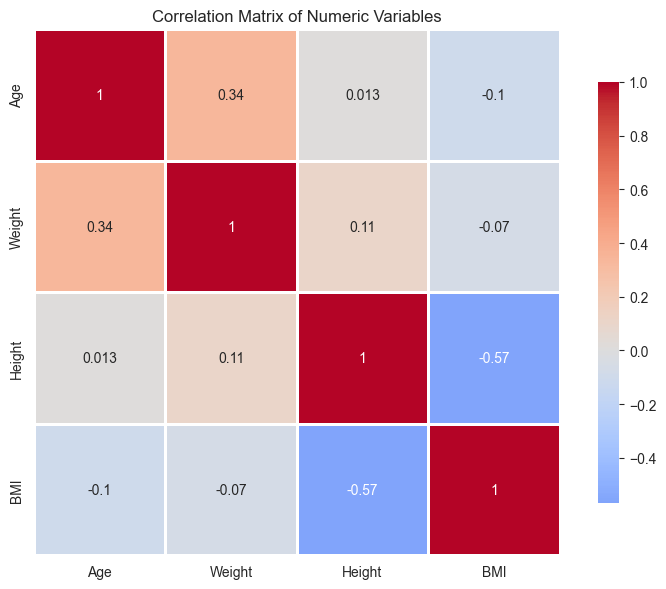

In [20]:
# Correlation analysis
print("Correlation Matrix:")
numeric_cols = ['Age', 'Weight', 'Height', 'BMI']
correlation_matrix = df_clean[numeric_cols].corr()
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

### 7. Data Visualization

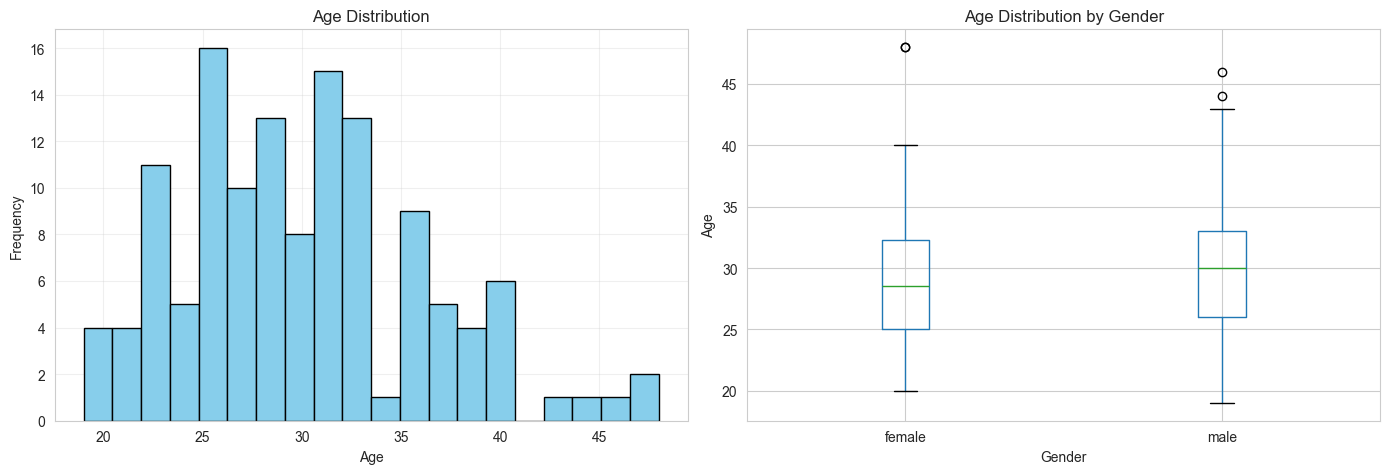

In [21]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_clean['Age'].dropna(), bins=20, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution')
axes[0].grid(True, alpha=0.3)

# Box plot by gender
df_clean.boxplot(column='Age', by='Gender', ax=axes[1])
axes[1].set_title('Age Distribution by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Age')

plt.suptitle('')
plt.tight_layout()
plt.show()

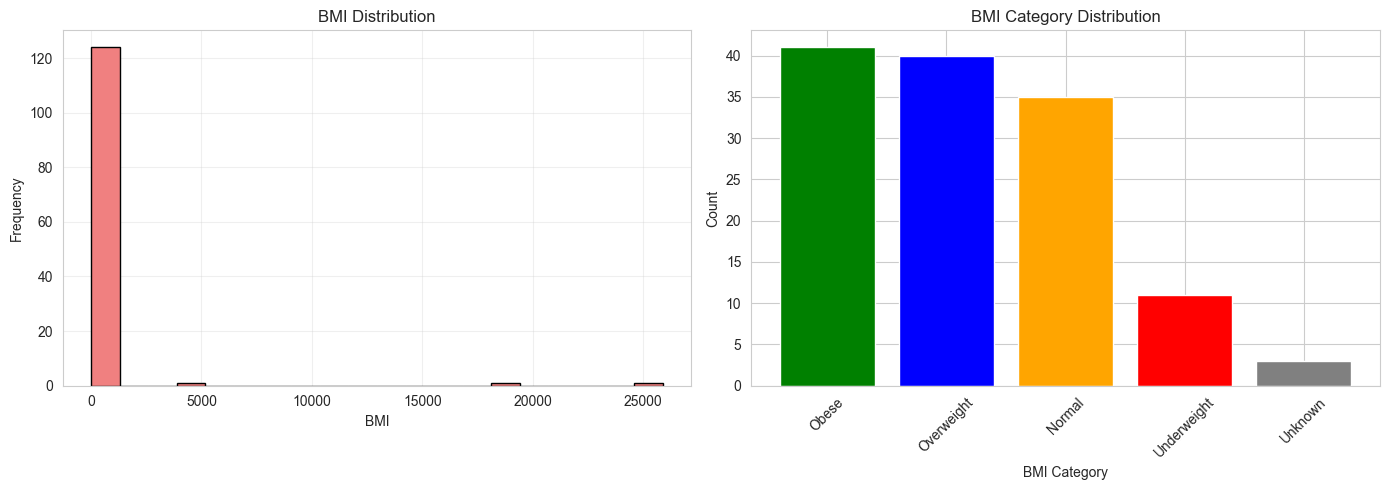

In [22]:
# BMI distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_clean['BMI'].dropna(), bins=20, color='lightcoral', edgecolor='black')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Frequency')
axes[0].set_title('BMI Distribution')
axes[0].grid(True, alpha=0.3)

# BMI Category distribution
bmi_counts = df_clean['BMI_Category'].value_counts()
axes[1].bar(bmi_counts.index, bmi_counts.values, color=['green', 'blue', 'orange', 'red', 'gray'])
axes[1].set_xlabel('BMI Category')
axes[1].set_ylabel('Count')
axes[1].set_title('BMI Category Distribution')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

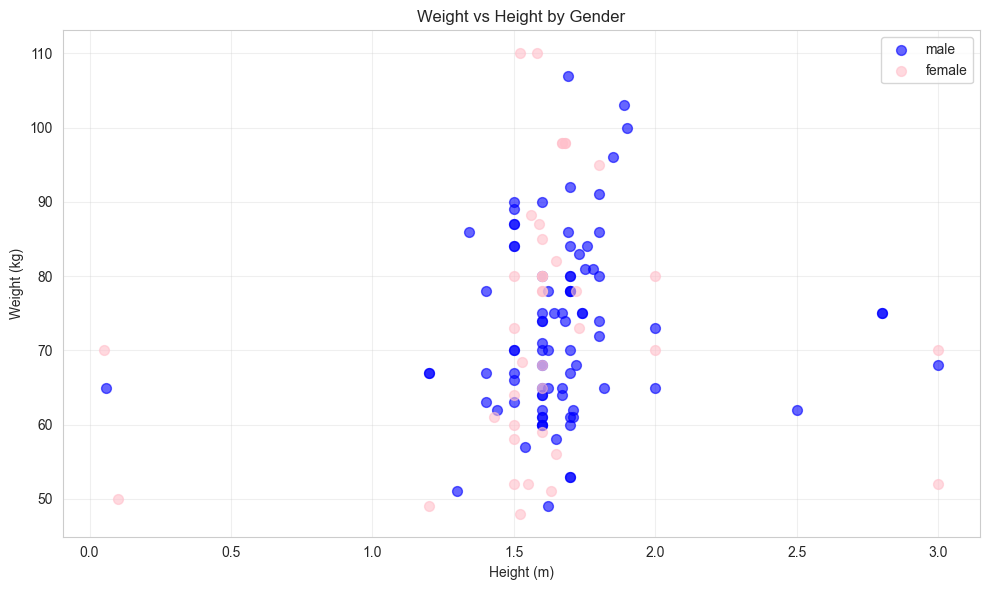

In [23]:
# Weight vs Height scatter plot
plt.figure(figsize=(10, 6))
colors = {'male': 'blue', 'female': 'pink'}
for gender in df_clean['Gender'].unique():
    if pd.notna(gender):
        subset = df_clean[df_clean['Gender'] == gender]
        plt.scatter(subset['Height'], subset['Weight'], 
                   label=gender, alpha=0.6, s=50, color=colors.get(gender, 'gray'))

plt.xlabel('Height (m)')
plt.ylabel('Weight (kg)')
plt.title('Weight vs Height by Gender')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/ws/5yhyzg_56qbfqs_drrgggh4m0000gp/T/ipykernel_87475/1451837316.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(gender_groups, labels=df_clean_no_na['Gender'].unique())


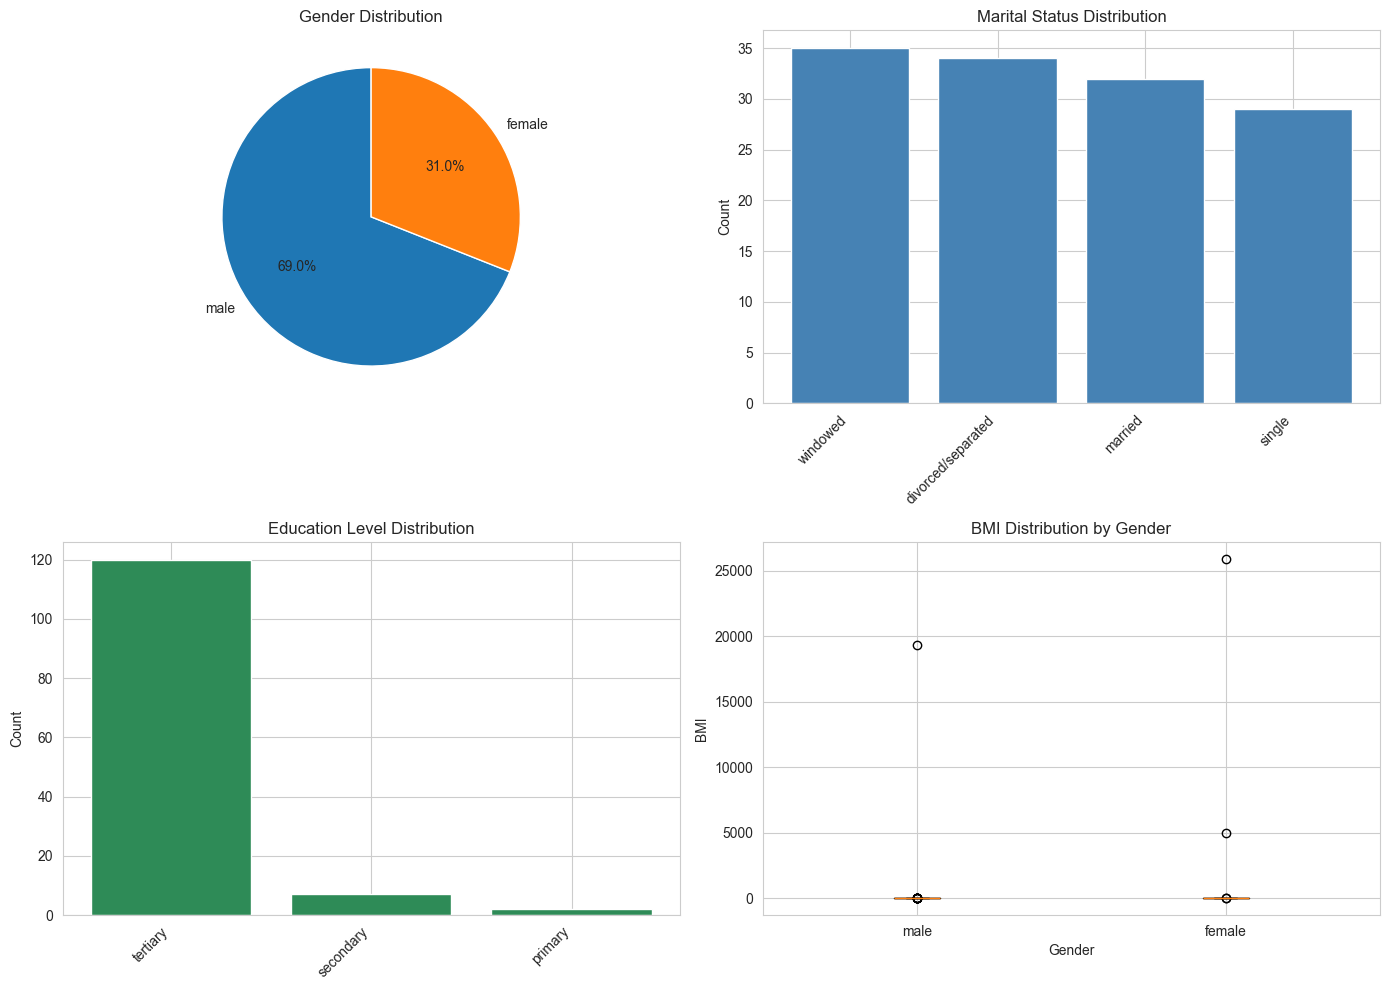

In [24]:
# Demographic distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gender distribution
gender_counts = df_clean['Gender'].value_counts()
axes[0, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Gender Distribution')

# Marital status distribution
marital_counts = df_clean['MaritalStatus'].value_counts()
axes[0, 1].bar(range(len(marital_counts)), marital_counts.values, color='steelblue')
axes[0, 1].set_xticks(range(len(marital_counts)))
axes[0, 1].set_xticklabels(marital_counts.index, rotation=45, ha='right')
axes[0, 1].set_title('Marital Status Distribution')
axes[0, 1].set_ylabel('Count')

# Education distribution
education_counts = df_clean['Education'].value_counts()
axes[1, 0].bar(range(len(education_counts)), education_counts.values, color='seagreen')
axes[1, 0].set_xticks(range(len(education_counts)))
axes[1, 0].set_xticklabels(education_counts.index, rotation=45, ha='right')
axes[1, 0].set_title('Education Level Distribution')
axes[1, 0].set_ylabel('Count')

# BMI by Gender
df_clean_no_na = df_clean.dropna(subset=['Gender', 'BMI'])
gender_groups = [df_clean_no_na[df_clean_no_na['Gender'] == g]['BMI'].values 
                 for g in df_clean_no_na['Gender'].unique()]
axes[1, 1].boxplot(gender_groups, labels=df_clean_no_na['Gender'].unique())
axes[1, 1].set_title('BMI Distribution by Gender')
axes[1, 1].set_ylabel('BMI')
axes[1, 1].set_xlabel('Gender')

plt.tight_layout()
plt.show()

### 8. Save Processed Data

In [25]:
# Save the processed data
output_path = 'data_clearance/output_processed.csv'
df_clean.to_csv(output_path, index=False)
print(f"Processed data saved to: {output_path}")

# Display summary
print(f"\nProcessed Dataset Summary:")
print(f"Total records: {len(df_clean)}")
print(f"Columns: {', '.join(df_clean.columns)}")
print(f"\nData types:")
print(df_clean.dtypes)

Processed data saved to: data_clearance/output_processed.csv

Processed Dataset Summary:
Total records: 130
Columns: Age, MaritalStatus, Gender, Education, Weight, Height, BMI, BMI_Category

Data types:
Age              float64
MaritalStatus        str
Gender               str
Education            str
Weight           float64
Height           float64
BMI              float64
BMI_Category         str
dtype: object


### 9. Final Summary Report

In [26]:
# Generate comprehensive summary report
print("="*80)
print("BIOMEDICAL DATA PROCESSING - FINAL REPORT")
print("="*80)

print(f"\n1. DATASET OVERVIEW")
print(f"   - Total Records: {len(df_clean)}")
print(f"   - Total Variables: {len(df_clean.columns)}")
print(f"   - Date Processed: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n2. DATA QUALITY")
print(f"   - Records with complete data: {df_clean.dropna().shape[0]} ({df_clean.dropna().shape[0]/len(df_clean)*100:.1f}%)")
print(f"   - Records with missing values: {len(df_clean) - df_clean.dropna().shape[0]}")

print(f"\n3. DEMOGRAPHIC SUMMARY")
print(f"   - Age Range: {df_clean['Age'].min():.0f} - {df_clean['Age'].max():.0f} years")
print(f"   - Mean Age: {df_clean['Age'].mean():.1f} years")
print(f"   - Gender Distribution:")
for gender, count in df_clean['Gender'].value_counts().items():
    print(f"     * {gender}: {count} ({count/len(df_clean)*100:.1f}%)")

print(f"\n4. HEALTH METRICS")
print(f"   - Mean Weight: {df_clean['Weight'].mean():.1f} kg")
print(f"   - Mean Height: {df_clean['Height'].mean():.2f} m")
print(f"   - Mean BMI: {df_clean['BMI'].mean():.1f}")
print(f"   - BMI Categories:")
for category, count in df_clean['BMI_Category'].value_counts().items():
    print(f"     * {category}: {count} ({count/len(df_clean)*100:.1f}%)")

print(f"\n5. OUTPUT")
print(f"   - Processed file: {output_path}")
print(f"   - Jupyter notebook: process_data.ipynb")

print("\n" + "="*80)
print("Processing completed successfully!")
print("="*80)

BIOMEDICAL DATA PROCESSING - FINAL REPORT

1. DATASET OVERVIEW
   - Total Records: 130
   - Total Variables: 8
   - Date Processed: 2026-01-28 23:34:54

2. DATA QUALITY
   - Records with complete data: 127 (97.7%)
   - Records with missing values: 3

3. DEMOGRAPHIC SUMMARY
   - Age Range: 19 - 48 years
   - Mean Age: 30.1 years
   - Gender Distribution:
     * male: 89 (68.5%)
     * female: 40 (30.8%)

4. HEALTH METRICS
   - Mean Weight: 73.0 kg
   - Mean Height: 1.65 m
   - Mean BMI: 422.1
   - BMI Categories:
     * Obese: 41 (31.5%)
     * Overweight: 40 (30.8%)
     * Normal: 35 (26.9%)
     * Underweight: 11 (8.5%)
     * Unknown: 3 (2.3%)

5. OUTPUT
   - Processed file: data_clearance/output_processed.csv
   - Jupyter notebook: process_data.ipynb

Processing completed successfully!
